<a href="https://colab.research.google.com/github/Lewis34cs/corona_audio/blob/main/covid_proj_p1_xrays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project Part 1: Chest X-Ray Multi Classification

>Author: Chris Lewis

>Contact info: lewis34cs@gmail.com


>- Link to [Project repo](https://github.com/Lewis34cs/corona_audio)
  - Part 1: [`covid_proj_p1_xrays.ipynb`](https://colab.research.google.com/drive/175EDoT7ACYu5JbIgEoFx9DboHzGiWdq2#scrollTo=2DJlDc99-sC5)(This Notebook)
  - Part 2: [`covid_proj_p2_audio.ipynb`](https://colab.research.google.com/drive/1s4z-GJnNkE2NCx5MVccXxXzvBIc__tTX#scrollTo=WjwyDrj8S80W)

#### COVID-19 Exploration in statistics and diagnosis via imaging and audio

>Since the beginning of 2020, COVID-19 has run rampant throughout the entirety of the globe, resulting in over 100 million cases and 2 million deaths. While vaccines are beginning to be pushed out as our new line of defense, my project's goal is to try and identify other ways to detect COVID-19 in a patient to help slow the spread. In this project, I focus on two different ways to identify COVID-19: multi classification via chest x-rays and binary classification through coughing audio. Both parts will be using Sequential Convolutional Neural Networks. This notebook will focus on COVID-19 diagnosis using chest x-ray images obtained from Kaggle's API.

>To run the Google Colab code, you must allow Google Colab to access an account. I will provide links for the data below. Please be sure to save zipped folders for these audio datasets into your google drive so you can access them on Google Colab. The chest x-ray database was obtained via Kaggle's API.

>- **Chest X-ray Database**: https://www.kaggle.com/tawsifurrahman/covid19-radiography-database
- Link for functions and zipped audio datasets: https://drive.google.com/drive/folders/1IQ758RksB0ayUhOohfGh8s25MT4taMsI?usp=sharing


Click on the "add to drive" button once you've clicked on the Google Drive link above to add the datasets and functions to your Google Drive
<img src='https://drive.google.com/uc?id=1YYdx9_xhHRsYLqV2X7yUJauG9zKX_LoX'>

#### Mounting Google Drive

>We must run this in order for colab to be able to access our google drive. We can have google colab mount our google drive by either running the cell below or clicking on the folder icon on the left navigation bar and then clicking on the "Mount Drive" button at the top of the navigation pane.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# We need to import these libraries in order to access the shared folder
import os, sys

In [3]:
# We must install these libraries for our imported functions folder to work
!pip install split-folders
!pip install split-folders tqdm
!pip install pydub
!pip install soundfile
!pip install ffmpeg-python
!pip install zip_files
!pip install lime
!pip install tensorflow_addons

     |████████████████████████████████| 276kB 16.0MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283846 sha256=da3876c18ac97de3f21b9cb41b46b49fe955fb6995b92f77e5475f267340bfa5
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime
     |████████████████████████████████| 706kB 13.4MB/s 


>Set the 'FOLDER' variable as the filepath where the folder containing functions.py and audio datasets are located in your Google Drive.

In [4]:
FOLDER = '/content/drive/MyDrive/chris_lewis_capstone/'
os.listdir(FOLDER)

['public_dataset.zip', 'virufy_data-main.zip', '__pycache__', 'functions.py']

>Defining a path variable (our FOLDER) to add a specific path for the interpreter to search for and then load the filepath into the extensions in order to import all the functions from the functions.py file.

In [5]:
sys.path.append(FOLDER)

In [6]:
%load_ext autoreload
%autoreload 2
from functions import *

#### Importing Libraries

>These are the libraries we used in the project. Note that it is not necessary to run these cells because the functions.py file has already imported the libraries for us.

In [7]:
#Setting seeds first in order to achieve better consistency in scoring
import numpy as np
import tensorflow as tf

np.random.seed(321)
tf.random.set_seed(321)

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import os, sys, glob, shutil

In [9]:
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.utils import class_weight
from skimage.segmentation import mark_boundaries
import time
from IPython.display import Image, display
from PIL import Image as Im
import cv2
import shutil
from google.colab import files

# tensorflow libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [10]:
import splitfolders
import lime
from lime import lime_image
from zipfile import ZipFile

In [11]:
# setting plot background style
plt.style.use('dark_background')

# PART 1: Classifying COVID-19 Chest X-ray Images via Sequential Convolutional Neural Network

In [12]:
# Viewing where we are in the directory
os.path.abspath(os.curdir)

'/content'

## Obtaining COVID CXR dataset via Kaggle API

>In order to obtain the chest x-ray database from Kaggle, we make a call to Kaggle's API using an API key. This database still updates regularly, which means that more images are placed into each class, giving us more data to train off of. Instead of downloading the file manually to our google drive, we prefer this route in order to avoid having to constantly check for database updates. 

>The dataset for this part can be found on Kaggle:
-  Chest X-ray database: 
  - https://www.kaggle.com/tawsifurrahman/covid19-radiography-database. 
- For instructions on how to get an API key: https://www.kaggle.com/docs/api

>Once you have the API key, please upload it in the cell below.
The below cells are retrieved from Kaggle.

In [13]:
# Hiding my key by having a variable store the info
API_key = files.upload()

Saving kaggle.json to kaggle.json


In [14]:
# Creating a hidden folder then copying my API key and putting it in that file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [15]:
# Permissions of 600 mean that I (the owner) have full read and write access to the 
# file, while no other user can access or edit the file
!chmod 600 ~/.kaggle/kaggle.json

In [16]:
# Downloading the zipped dataset via Kaggle's API
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

 99% 1.13G/1.14G [00:12<00:00, 88.3MB/s]
100% 1.14G/1.14G [00:12<00:00, 100MB/s] 


#### Unzipping Folder Contents

>Unzipping the file and extracting to the root directory. If you chose to directly download the database from the kaggle page instead of making a call to the API, replace the 'f_name' variable with the location of the zipped file in your Google Drive. Do not unzip the zipped folder before loading into Google Colab.

In [17]:
f_name = "covid19-radiography-database.zip"

with ZipFile(f_name, 'r') as zipf:
      zipf.extractall()
      print('Done')

Done


In [18]:
# removing unnecessary files
!rm /content/covid19-radiography-database.zip
!rm /content/kaggle.json

In [19]:
# Setting directory location to root directory
%cd ~
%cd ..

/root
/


In [20]:
# setting a variable called cxr_base_folder that contains the directory of where 
# our chest x-ray images are
cxr_base_folder = ensure_filepath('/content/COVID-19 Radiography Database')

In [21]:
# Viewing the contents within our cxr_base_folder
folder_contents(cxr_base_folder)

Contents of /content/COVID-19 Radiography Database/:



['COVID',
 'COVID.metadata.xlsx',
 'NORMAL',
 'NORMAL.metadata.xlsx',
 'README.md.txt',
 'Viral Pneumonia',
 'Viral Pneumonia.metadata.xlsx']

#### Identifying the number of images in our dataset

In [22]:
total_image_number = num_items(cxr_base_folder)

/content/COVID-19 Radiography Database/
Number of items in COVID: 1200
Number of items in NORMAL: 1341
Number of items in Viral Pneumonia: 1345
Total number of items: 3886


>From here, we view the extracted contents and count the number of images per class along with the total image count. We see that we are working with 3800+ images.

### Splitting our images into train, test, and validation sets

>Here, we are making a folder to store our train, test, and validation folders. If you would like to store the folders in another filepath, please specify where you would like to store your train, test, and validation folders in the 'cxr_folders' variable. Note that this folder is temporary and will be deleted later on.

In [23]:
cxr_folders = ensure_filepath('/content/cxr_folders')

os.makedirs(cxr_folders, exist_ok=True)

#### Temporary Folder Creation & Check

>The splitfolders library is extremely effective and very easy to use. It allows us to feed in a directory address (base_folder variable) and give it a place to put the new train, test, and validation folders (output variable). Note that the output address must already be existing. We also set a seed in order to help with model score reproducibility when training our models. The ratio parameter required floats that determines the percentage of data going to each folder.
- For more info about the splitfolders library, click here: https://github.com/jfilter/split-folders

In [24]:
splitfolders.ratio(input=cxr_base_folder, 
                    output=cxr_folders, 
                    seed=42, ratio=(0.7, 0.1, 0.2)) # ratio order: train, val, test

Copying files: 3886 files [00:11, 343.00 files/s]


## Recommendation:

>If you prefer working with folder structures when dealing with training and testing data, I would highly recommend using the splitfolders library. Through the use of this library, I was able to create train, test, and validation folders, create image data generators, and have those generators access the data by flowing the data from my directories. 

In [25]:
folder_check(new_dir=cxr_folders, orig_dir=cxr_base_folder, check=1)

/content/cxr_folders/train/
Number of items in NORMAL: 938
Number of items in COVID: 840
Number of items in Viral Pneumonia: 941
Total number of items: 2719

/content/cxr_folders/test/
Number of items in NORMAL: 269
Number of items in COVID: 240
Number of items in Viral Pneumonia: 270
Total number of items: 779

/content/cxr_folders/val/
Number of items in NORMAL: 134
Number of items in COVID: 120
Number of items in Viral Pneumonia: 134
Total number of items: 388

/content/COVID-19 Radiography Database/
Number of items in COVID: 1200
Number of items in NORMAL: 1341
Number of items in Viral Pneumonia: 1345
Total number of items: 3886

Are the image numbers equal?
True

Total image count: 3886


In [26]:
# Creating variables to hold our addresses for our train, test, and val folders
train_folder, test_folder, val_folder = create_ttv(cxr_folders)

In [27]:
train_folder

'/content/cxr_folders/train/'

>Since we are using a DummyClassifier as our baseline model, it cannot work with ImageDataGenerators. So instead, we will create X and y train, test, and validation variables by feeding in a batch size equal to the amount of data in each train, test, and validation folder.

In [28]:
TRAIN_BATCH_SIZE, TEST_BATCH_SIZE, VAL_BATCH_SIZE = batch_sizes([train_folder, 
                                                                 test_folder, 
                                                                 val_folder])
print(f"Train batch size: {TRAIN_BATCH_SIZE}\nTest batch size: {TEST_BATCH_SIZE}"
      f"\nValidation batch size: {VAL_BATCH_SIZE}")

Train batch size: 2719
Test batch size: 779
Validation batch size: 388


#### Setting up ImageDataGenerators

>Setting up our variables for the dummy classifier

In [29]:
# Defining our image size
IMG_SIZE = (128, 128)

# Creating ImageDataGenerators for train and test/val
train_datagen = ImageDataGenerator(rescale=1./255)
test_val_datagen = ImageDataGenerator(rescale=1./255)

In [30]:
dummy_train_generator = train_datagen.flow_from_directory(train_folder, 
                                                   target_size=IMG_SIZE,
                                                   batch_size=TRAIN_BATCH_SIZE,
                                                   class_mode='categorical')

dummy_test_generator = test_val_datagen.flow_from_directory(test_folder, 
                                                     target_size=IMG_SIZE,
                                                     batch_size=TEST_BATCH_SIZE,
                                                     class_mode='categorical')

dummy_val_generator = test_val_datagen.flow_from_directory(val_folder, 
                                                    target_size=IMG_SIZE,
                                                    batch_size=VAL_BATCH_SIZE,
                                                    class_mode='categorical')

Found 2719 images belonging to 3 classes.
Found 779 images belonging to 3 classes.
Found 388 images belonging to 3 classes.


In [31]:
# Viewing the classes within our iterator
dummy_train_generator.class_indices

{'COVID': 0, 'NORMAL': 1, 'Viral Pneumonia': 2}

>Here is where we create our X and y variables for each train, test, and validation set. Notice that by calling next() on each iterator, we are feeding X and y variables data and labels equivalent to the batch sizes of the respective entire folder. 

In [32]:
start = time.time()
# Creating X and y values for dummy train, test, and validation sets
X_train, y_train = next(dummy_train_generator)
X_test, y_test = next(dummy_test_generator)
X_val, y_val = next(dummy_val_generator)

end = time.time()
time_count(start, end)

Time to run cell: 40 seconds


NORMAL : Class 1


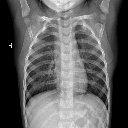

In [33]:
random_image(X_train, np.argmax(y_train, axis=1), verbose=1)

#### Baseline Model

>We need to one-hot encode our classes from our generated labels in order for the confusion matrix to be able to understand the we are working with more than two classes.

In [34]:
# Creating and fitting our dummy classifier
dummy = DummyClassifier(strategy='stratified')
dummy.fit(X_train, y_train)

# Creating our y_pred variable
y_pred = dummy.predict(X_test)

y_pred = np.argmax(y_pred, axis=1)
y_test_ohe = np.argmax(y_test, axis=1)

              precision    recall  f1-score   support

           0       0.32      0.64      0.42       240
           1       0.36      0.26      0.30       269
           2       0.38      0.14      0.21       270

    accuracy                           0.34       779
   macro avg       0.35      0.35      0.31       779
weighted avg       0.35      0.34      0.31       779



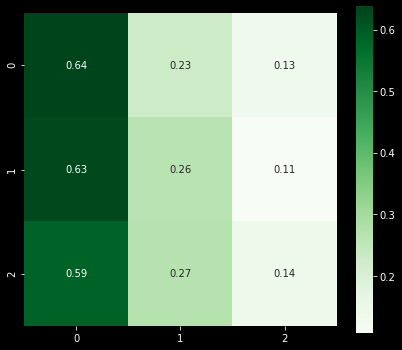

In [35]:
#Printing classification report and plotting confusion matrix
print(metrics.classification_report(y_test_ohe, y_pred));

plt.figure(figsize=(7, 6))
cm = metrics.confusion_matrix(y_test_ohe, y_pred, labels = [0, 1, 2], 
                              normalize='true')
sns.heatmap(cm, cmap="Greens", annot=True, square=True)
plt.show()

>We built a baseline dummy classifier model that has an accuracy of 34%, and it tends to guess for the class == 0, which is our Covid class. Since our dataset is relatively balanced in terms of classes, we expect to see the accuracy be around 33%.

## First CNN Model for CXRs

>Now we will create new generators that we will feed into a CNN model. Notice for the test generator we must set the parameter shuffle=False. This is because when we want to evaluate the model, we want be able to see the model's actual score against the test generator. If we were to set shuffle=True for the test generator, the labels in the test generator would not line up with the images when trying to evaluate the model.

In [36]:
train_generator = train_datagen.flow_from_directory(train_folder, 
                                                   target_size=IMG_SIZE,
                                                   batch_size=32,
                                                   class_mode='categorical')

test_generator = test_val_datagen.flow_from_directory(test_folder, 
                                                     target_size=IMG_SIZE,
                                                     batch_size=32,
                                                     class_mode='categorical', 
                                                     shuffle=False)

val_generator = test_val_datagen.flow_from_directory(val_folder, 
                                                    target_size=IMG_SIZE,
                                                    batch_size=32,
                                                    class_mode='categorical')

Found 2719 images belonging to 3 classes.
Found 779 images belonging to 3 classes.
Found 388 images belonging to 3 classes.


In [37]:
# Defining input shape to feed into our CNN
INPUT_SHAPE = train_generator.image_shape

#### Viewing our Class Weights

>We will now create a dictionary containing the weights for each class by using our custom make_class_weights() function.

In [38]:
class_weights_dict = make_class_weights(train_generator)

{0: 1.078968253968254, 1: 0.9662402274342573, 2: 0.963159759121502}


### Creating CNN Model

In [39]:
def create_basic_cnn(shape='',
                     metrics=['acc', tf.keras.metrics.Precision(name='precision'),
                              tf.keras.metrics.Recall(name='recall'), 
                              tf.keras.metrics.AUC(name='auc')]):
  """
  Definition:
  Creates a basic cnn model consisting of three layers and an output layer.

  Args:
  shape: this function requires an input shape in order for the model to be created.

  Returns:
  Returns a compiled model.
  """
  # We are requiring an input shape since we print the model.summary() at the 
  # end of the function
  if len(shape) < 1:
    print('Please define input shape!')
  else:
    # Input layer
    model = Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=shape))
    model.add(MaxPooling2D((2, 2)))

    # Second layer
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
      
    # Third layer
    model.add(Flatten())
    model.add(layers.Dense(128, activation='relu'))
      
    # Output layer
    model.add(layers.Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)
    print(model.summary())
    return model

In [40]:
basic_model = create_basic_cnn(shape=INPUT_SHAPE)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               7372928   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

### Fitting model, Plotting scores, Reporting evaluation

>The fit_plot_report_gen() function takes in a CNN model and fits it on a training generator. After each epoch the validation generator is evaluated, which allows us to see if the model is learning or overfitting. Once the model finishes training, we evaluate the test generator and create a classification report, confusion matrix, and a plot for each metric that was scored over the epochs.

Epoch 1/5
85/85 [==============================] - 39s 403ms/step - loss: 1.0934 - acc: 0.6680 - precision: 0.7188 - recall: 0.4933 - auc: 0.8033 - val_loss: 0.1784 - val_acc: 0.9330 - val_precision: 0.9378 - val_recall: 0.9330 - val_auc: 0.9915
Epoch 2/5
85/85 [==============================] - 33s 385ms/step - loss: 0.1626 - acc: 0.9379 - precision: 0.9384 - recall: 0.9345 - auc: 0.9922 - val_loss: 0.1238 - val_acc: 0.9562 - val_precision: 0.9585 - val_recall: 0.9536 - val_auc: 0.9938
Epoch 3/5
85/85 [==============================] - 33s 384ms/step - loss: 0.1193 - acc: 0.9546 - precision: 0.9551 - recall: 0.9543 - auc: 0.9950 - val_loss: 0.1289 - val_acc: 0.9665 - val_precision: 0.9689 - val_recall: 0.9639 - val_auc: 0.9945
Epoch 4/5
85/85 [==============================] - 33s 386ms/step - loss: 0.0786 - acc: 0.9729 - precision: 0.9741 - recall: 0.9697 - auc: 0.9983 - val_loss: 0.0987 - val_acc: 0.9768 - val_precision: 0.9793 - val_recall: 0.9742 - val_auc: 0.9942
Epoch 5/5
85/85 

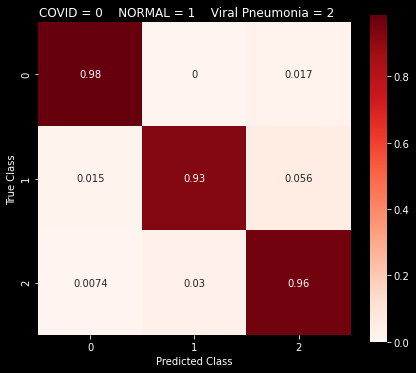

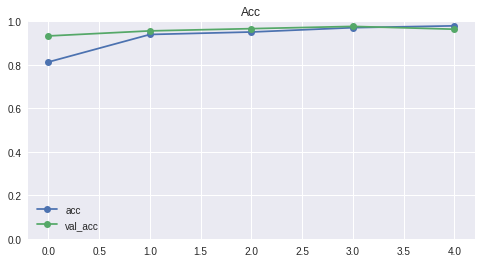

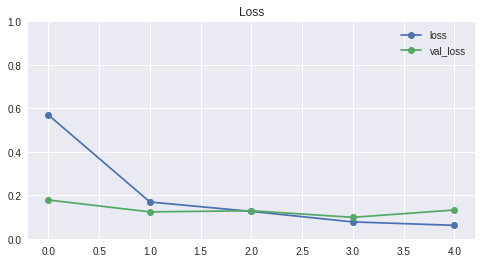

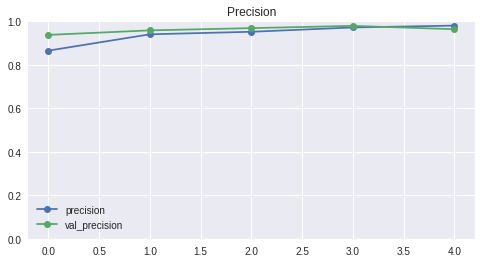

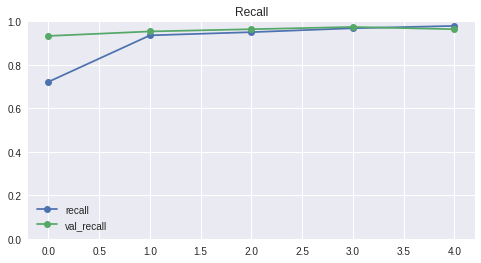

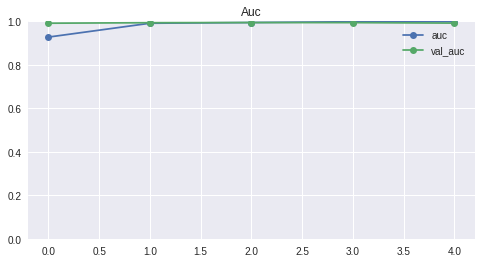

------------------------------------------------------------
25/25 [==============================] - 8s 333ms/step - loss: 0.1767 - acc: 0.9576 - precision: 0.9575 - recall: 0.9551 - auc: 0.9905
loss score: 0.1766771823167801
accuracy score: 0.9576380252838135
precision score: 0.9575289487838745
recall score: 0.9550706148147583
auc score: 0.9904612898826599

Time to run cell: 187 seconds


In [41]:
hist1 = fit_plot_report_gen(basic_model, train_generator, test_generator, val_generator, 
                class_weights=class_weights_dict, epochs=5, batch_size=32)

>While the above model seems to be performing extremely well with an accuracy of 94.6%, we would like to improve the recall rate (94.6%) for our COVID class. Since COVID-19 is able to spread so easily, the less people that are diagnosed as false negatives, the better. 6% may seem like a small number of false negatives, but if we were to diagnose 1,000,000 people who were COVID positive, we would have around 60,000 COVID positive cases that were wrongly identified as being another class.

>Based on prior experience when working with pneumonia chest x-rays in my previous project, it is extremely important for us to feed in chest x-ray images of high quality in order to score extremely well. For this next portion, we will be using CLAHE as a preprocessing technique to enhance the images before they are fed into the model. In doing so, hopefully we will see an increase in recall rate for the COVID class and an overall increase in accuracy. 

>- Link to [Pneumonia Project repo](https://github.com/Lewis34cs/cloudy_lungs)
  - Part 1: [`pneumonia_proj.ipynb`](https://colab.research.google.com/drive/1pMKRsWUJ5pnAGUp_W01nB9fitP57F0Sc)

In [42]:
# removing unpreprocessed CXR train, test, and val folder directory
try:
  shutil.rmtree(cxr_folders)
except:
  pass

## CLAHE Preprocessing Techniques

>Contrast Limited Adaptive Histogram Equalization (CLAHE) is used to equalize pixel intensity in images. It is very similar to Adaptive Histogram Equalization (AHE), except it doesn't over-amplify the contrast of the image. This is controlled by the clipLimit parameter. The way CLAHE works on an image is that it focuses on small portions of the image (tileGridSize parameter) and then combines these portions together through bilinear interpolation to help remove any artificial boundaries, which means that it enhances the local contrast of the total image. This essentially helps with the pixel intensity distribution, allowing us to see more "depth" in an image.

>link for info on cv2.createCLAHE(): https://docs.opencv.org/master/d6/dc7/group__imgproc__hist.html#gad689d2607b7b3889453804f414ab1018

>Here we are splitting up classes so we are able to view an example image of each class before CLAHE and then comparing the before-and-after images side by side.

In [43]:
# Defining classes
covid = ('Covid Class', 'COVID/COVID')
normal = ('Healthy Class', 'NORMAL/NORMAL')
pneumo = ('Viral Pneumonia Class', 'Viral Pneumonia/Viral Pneumonia')

In [44]:
class_select = input(f'Please select one of the classes to view: '
                     f'[covid][normal][pneumo] ')
if class_select == 'covid':
  selected_class = covid
elif class_select == 'normal':
  selected_class = normal
elif class_select == 'pneumo':
  selected_class = pneumo
try:
  # choosing a random image within the selected class folder
  i = np.random.choice(range(len(os.listdir(cxr_base_folder+selected_class[1].split('/')[0]))))
  img = cv2.imread(cxr_base_folder + selected_class[1] + f' ({i}).png', 0)
  print(f'Successfully loaded in an image from {selected_class[0]}')
  print(f"Image size: {img.shape}")
except:
  print('Error: No class with that name exists')

Please select one of the classes to view: [covid][normal][pneumo] covid
Successfully loaded in an image from Covid Class
Image size: (256, 256)


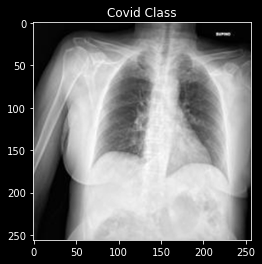

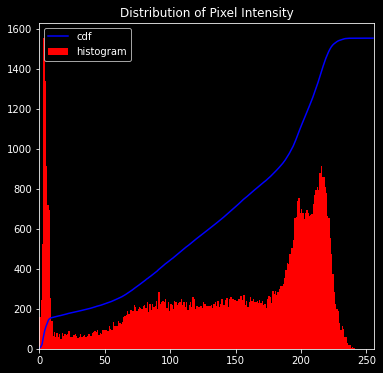

In [45]:
# Plotting an image to view, along with distribution of pixel intensity

plt.title(selected_class[0])
plt.imshow(img, cmap='gray')
hist,bins = np.histogram(img.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

plt.figure(figsize=(6, 6))
plt.title('Distribution of Pixel Intensity')
plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()


>As we can see here, the distribution of pixel intensity in our unpreprocessed image ranges from 0 to around 220. The way CLAHE works on an image is that it focuses on small portions of the image (tileGridSize parameter) and then combines these portions together through **bilinear interpolation** = a resampling method that uses the distance-­weighted average of the X nearest pixel values to estimate a new pixel value. Bilinear interpolation helps remove any artificial boundaries, which enhances the local contrast of the total image.

### Creating CLAHE preprocessed images and placing them into new directory

>Creating a new folder in the 'cxr_clahe_folder' variable to store our CLAHE preprocessed images. If you would like to store the folders in another filepath, please specify where you would like to store your train, test, and validation folders in the 'cxr_clahe_folder' variable. Note that this folder is temporary and will be deleted later on.

In [46]:
# Please define a filepath where you would like the CLAHE preprocessed images to
# be stored in the 'new_folder' variable. This folder is temporary.
try:
  if os.path.exists(cxr_clahe_folder):
    print('CLAHE folder already exists')
except:
  cxr_clahe_folder = ensure_filepath('/content/clahe_radio')
  clahe_preprocessing(cxr_base_folder, cxr_clahe_folder)

Viral Pneumonia: 100%|██████████| 1345/1345 [00:38<00:00, 34.86it/s]

Time to run cell: 80 seconds


In [47]:
num_items(cxr_clahe_folder)

/content/clahe_radio/
Number of items in COVID: 1200
Number of items in NORMAL: 1341
Number of items in Viral Pneumonia: 1345
Total number of items: 3886


3886

In [48]:
# Setting original and CLAHE images to compare
orig_img = cv2.imread(cxr_base_folder + selected_class[1] + f' ({i}).png')
clahe_img = cv2.imread(cxr_clahe_folder + selected_class[1] + f' ({i}).png')

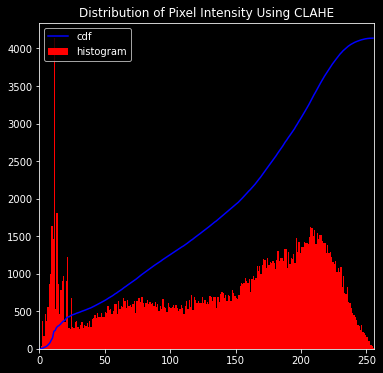

In [49]:
hist,bins = np.histogram(clahe_img.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

plt.figure(figsize=(6, 6))
plt.title('Distribution of Pixel Intensity Using CLAHE')
plt.plot(cdf_normalized, color = 'b')
plt.hist(clahe_img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()


>Note that we can see that the intensities of pixels, when compared to the original distribution, have become more spread out. This will give our image a 'deeper' look to it, and give our model more information for each image.

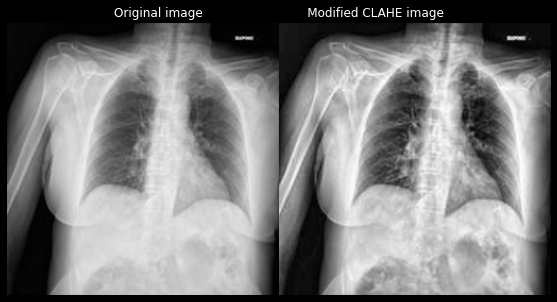

In [50]:
# Comparing original image (left) to CLAHE applied image (right)
res = np.hstack((orig_img,clahe_img))
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
plt.imshow(res, cmap='gray')
plt.title('Original image                           Modified CLAHE image')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)
plt.show()

>We can definitely see more of the infiltrate in the lung areas of the chest x-ray. These infiltrate areas of the lung can determine whether or not a person has Pneumonia. We can definitely see more of the infiltrate in the lung areas of the chest x-ray. These infiltrate areas of the lung can determine whether or not a person has Pneumonia. According to Hosseiny et al., when there is radiographic appearances of multifocal ground glass opacity, linear opacities, and consolidation, these are usually seen in cases of coronavirus type infections, including COVID-19, SARS, and MERS.

In [51]:
# Removing unpreprocessed images from our directory
try:
  shutil.rmtree(cxr_base_folder)
except:
  pass

>Splitting our preprocess image folder into train, test, and validation subfolders into a new directory. If you would like to store the folders in another filepath, please specify where you would like to store your train, test, and validation folders in the 'clahe_ttv_folder' variable. Note that this folder is temporary and will be deleted later on.

In [52]:
clahe_ttv_folder = ensure_filepath('/content/clahe_ttv')

splitfolders.ratio(input=cxr_clahe_folder, 
                    output=clahe_ttv_folder, 
                    seed=42, ratio=(0.7, 0.1, 0.2))

Copying files: 3886 files [00:05, 722.78 files/s]


In [53]:
# Removing base clahe images folder from our directory
try:
  if os.path.exists(clahe_ttv_folder):
    shutil.rmtree(cxr_clahe_folder)
except:
  print('Please run the cell above first')

In [54]:
folder_check(clahe_ttv_folder)

/content/clahe_ttv/train/
Number of items in NORMAL: 938
Number of items in COVID: 840
Number of items in Viral Pneumonia: 941
Total number of items: 2719

/content/clahe_ttv/test/
Number of items in NORMAL: 269
Number of items in COVID: 240
Number of items in Viral Pneumonia: 270
Total number of items: 779

/content/clahe_ttv/val/
Number of items in NORMAL: 134
Number of items in COVID: 120
Number of items in Viral Pneumonia: 134
Total number of items: 388


Total image count: 3886


## Modeling with CLAHE preprocessed images

>Defining new train, test, and validation folders for our CLAHE preprocessed chest x-ray images.

In [55]:
train_folder, test_folder, val_folder = create_ttv(clahe_ttv_folder)

In [56]:
# Still the same size as our previous model
IMG_SIZE = (128, 128)

In [57]:
train_clahe_datagen = ImageDataGenerator(rescale=1./255)

test_val_clahe_datagen = ImageDataGenerator(rescale=1./255)

cl_train_generator = train_clahe_datagen.flow_from_directory(train_folder, 
                                                   target_size=IMG_SIZE,
                                                   batch_size=32,
                                                   class_mode='categorical')

cl_test_generator = test_val_clahe_datagen.flow_from_directory(test_folder, 
                                                     target_size=IMG_SIZE,
                                                     batch_size=32,
                                                     class_mode='categorical', 
                                                     shuffle=False)

cl_val_generator = test_val_clahe_datagen.flow_from_directory(val_folder, 
                                                    target_size=IMG_SIZE,
                                                    batch_size=32,
                                                    class_mode='categorical')

Found 2719 images belonging to 3 classes.
Found 779 images belonging to 3 classes.
Found 388 images belonging to 3 classes.


In [58]:
INPUT_SHAPE = cl_train_generator.image_shape
print(INPUT_SHAPE)

(128, 128, 3)


In [59]:
class_weights_dict = make_class_weights(cl_train_generator)

{0: 1.078968253968254, 1: 0.9662402274342573, 2: 0.963159759121502}


In [60]:
basic_prep_cnn = create_basic_cnn(shape=INPUT_SHAPE)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               7372928   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

>Now that we've preprocessed our images, put the images into train, test, and validation folders, and created generators to feed into our model, we can now fit the model. Feel free to tweak the parameters of the three_callbacks() function. Make sure to read how the function works first if you choose to do so. Below are some recommendations for tweaking the function.

Epoch 1/10
85/85 [==============================] - 27s 306ms/step - loss: 1.5853 - acc: 0.5668 - precision: 0.8524 - recall: 0.6549 - auc: 0.9025 - val_loss: 0.2048 - val_acc: 0.9201 - val_precision: 0.9247 - val_recall: 0.9175 - val_auc: 0.9877
Epoch 2/10
85/85 [==============================] - 25s 294ms/step - loss: 0.1709 - acc: 0.9345 - precision: 0.9382 - recall: 0.9301 - auc: 0.9908 - val_loss: 0.1212 - val_acc: 0.9691 - val_precision: 0.9691 - val_recall: 0.9691 - val_auc: 0.9947
Epoch 3/10
85/85 [==============================] - 25s 298ms/step - loss: 0.1289 - acc: 0.9531 - precision: 0.9572 - recall: 0.9489 - auc: 0.9950 - val_loss: 0.1974 - val_acc: 0.9227 - val_precision: 0.9251 - val_recall: 0.9227 - val_auc: 0.9874
Epoch 4/10
85/85 [==============================] - 25s 295ms/step - loss: 0.0640 - acc: 0.9789 - precision: 0.9793 - recall: 0.9766 - auc: 0.9982 - val_loss: 0.2173 - val_acc: 0.9278 - val_precision: 0.9278 - val_recall: 0.9278 - val_auc: 0.9851
Epoch 5/10
8

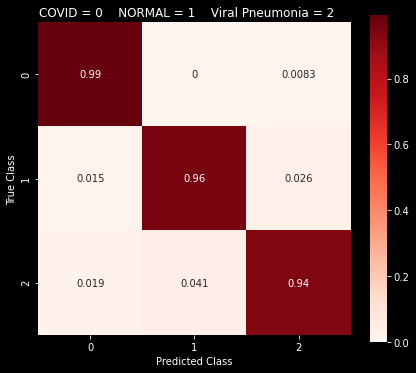

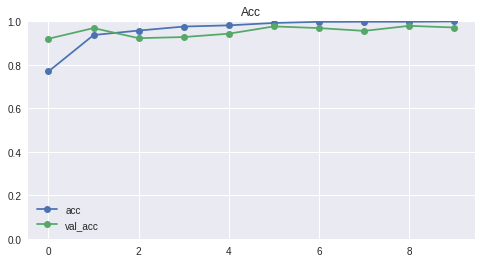

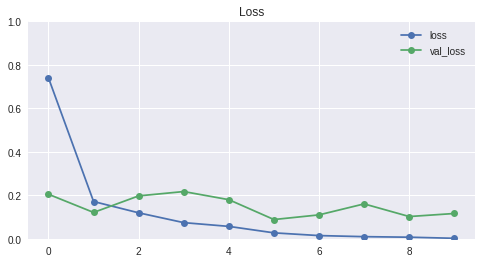

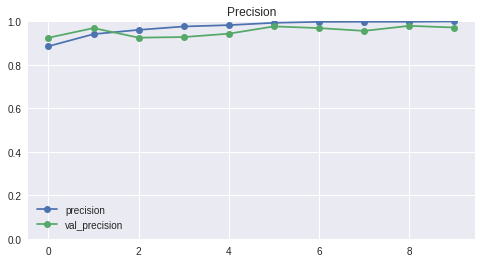

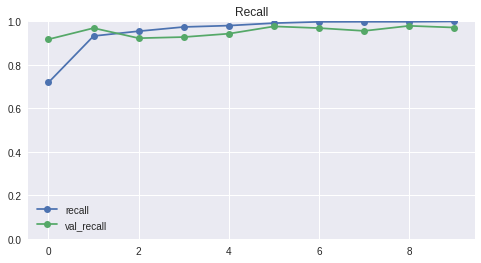

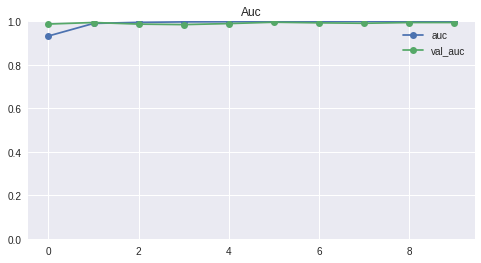

------------------------------------------------------------
25/25 [==============================] - 6s 254ms/step - loss: 0.1797 - acc: 0.9628 - precision: 0.9627 - recall: 0.9615 - auc: 0.9911
loss score: 0.17968153953552246
accuracy score: 0.962772786617279
precision score: 0.9627249240875244
recall score: 0.9614890813827515
auc score: 0.9910779595375061

Time to run cell: 268 seconds


In [ ]:
"""
Recommended parameters to play around with:
 - epochs
 - lr_patience
 - factor
 - patience
 - restore_best_weights

Please read the three_callbacks() function before changing!

Note that: 
 - patience should not be lower than lr_patience, otherwise learning rate decay
 will not occur.
 - Both patience and lr_patience should not be as large / larger than the number 
 of epochs
"""

# Please define a filepath to store all models that will be saved from the 
# ModelCheckpoint callback in the variable 'cxr_model_storage'. 
cxr_model_storage = ensure_filepath('/cxr_models/')

prep_hist = fit_plot_report_gen(basic_prep_cnn, cl_train_generator, 
                                cl_test_generator, cl_val_generator, 
                                epochs=10, batch_size=32,
                                class_weights=class_weights_dict, 
                                callbacks=three_callbacks(lr_patience=3, factor=0.9, 
                                                          patience=5, 
                                                          restore_best_weights=False,
                                                          f_path=cxr_model_storage))

#### Viewing what the model sees using lime image explainer

>By using the lime library, we create a function that explains what the model determines to be important factors (both positive and negative) when diagnosing an image. Positive factors are marked with green, and negative factors are marked with red. 

>For more information about the lime library: https://lime-ml.readthedocs.io/en/latest/lime.html#module-lime.lime_image

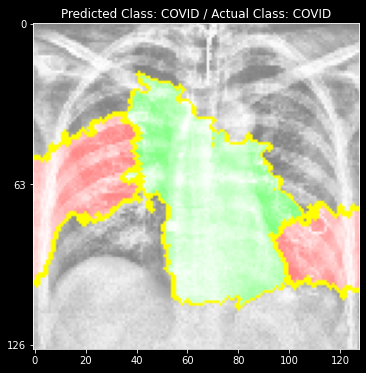

In [ ]:
explain_image(basic_prep_cnn, cl_train_generator, num_samples=2000, num_feats=3, 
              class_label=0)

### Saving best CXR models

>Now we define a filepath where we would like to save our best models. Please set a filepath for the 'best_models_filepath' variable where you would like to store your best models. Feel free to change the threshold, note that the lower the threshold, the more
models will be saved to the 'best_models_filepath'. Models that do not surpass the threshold are removed.

In [ ]:
best_models_filepath = ensure_filepath('/content/drive/MyDrive/gdrive/models/capstone_models/cxr_models/')
THRESHOLD = 0.96

move_best_models(source=cxr_model_storage, threshold=THRESHOLD,
                 new_dir=best_models_filepath, 
                 test_gen=cl_test_generator)

25/25 [==============================] - 7s 259ms/step - loss: 0.1352 - acc: 0.9564 - precision: 0.9624 - recall: 0.9538 - auc: 0.9939


>To load in a saved model, please specify the filepath where you saved the model and put into the 'model_fpath' variable.

---------------------------------------------------------
                  Classification Report

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       240
           1       0.95      0.98      0.96       269
           2       0.98      0.94      0.96       270

    accuracy                           0.97       779
   macro avg       0.97      0.97      0.97       779
weighted avg       0.97      0.97      0.97       779

---------------------------------------------------------


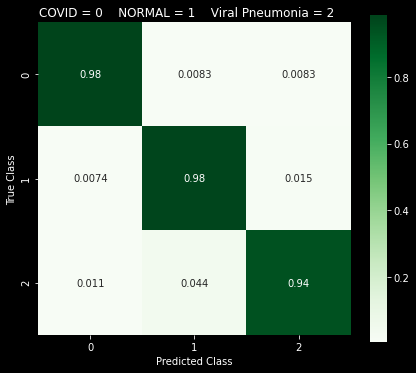

25/25 [==============================] - 7s 258ms/step - loss: 0.1188 - acc: 0.9679 - precision: 0.9704 - recall: 0.9679 - auc: 0.9941


[0.11884351074695587,
 0.9679075479507446,
 0.9703989624977112,
 0.9679075479507446,
 0.994138777256012]

In [ ]:
model_fpath = '/content/drive/MyDrive/gdrive/models/capstone_models/cxr_models/model-05-0.101.hdf5'

best_model = load_model(model_fpath)
class_report_gen(best_model, cl_test_generator, 
                 class_indices=test_generator.class_indices, cmap='Greens')
best_model.evaluate(cl_test_generator, verbose=1)

## Recommendation: 
>When working with images like x-rays or MRI scans, I highly recommend using CLAHE as a preprocessing technique to create new images that give the model more to learn from. CLAHE also is able to provide enough contrast to the image without overamplifying the intensity of the pixels. It is a great tool if the goal of your project involve detection and/or recognition.

In [61]:
# If you are finished with the above section and would like to continue, please
# set run = 1 to remove unecessary folders for Part 2
ans = input(f"All temporary files from Part 1 will be removed from the working "
            f"directory. Proceed? [y][n] ")
if ans.lower() == 'y':
  print("Removing files")
  try:
    shutil.rmtree(clahe_ttv_folder)
    shutil.rmtree(cxr_model_storage)
    print("Process completed")
  except:
    print("No folders were removed")
else:
  print("No folders were removed")

All temporary files from Part 1 will be removed from the working directory. Proceed? [y][n] y
Removing files
No folders were removed


# Part 1 Conclusions
>The scores of our best model show an improvement in both recall rate (98%) for the COVID class and overall accuracy (97%). By using CLAHE, our model was able to reduce the amount of false negatives from our previous model by 4%. CLAHE is a great preprocessing tool that many hospitals and facilities should use when diagnosing their patients for certain diseases that may affect the targeted x-ray area.


#### Caveats
>While using x-rays to diagnose patients with COVID has proven to be successful with the model we've created, the process of each person getting an x-ray to determine if they have COVID can be costly. Furthermore, we wouldn't want someone with COVID to come into a facility and expose healthy people to the virus. In Part 2, we are going to explore the possiblities of using cough audio from healthy and COVID infected individuals and see if we can create a model that can accurately diagnose those with COVID. 

## Part 2: Mel-Spectrogram Binary Classification

Link to Part 2: [`covid_proj_p2_audio.ipynb`](https://colab.research.google.com/drive/1s4z-GJnNkE2NCx5MVccXxXzvBIc__tTX#scrollTo=WjwyDrj8S80W)

## References

1. M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, M. T. Islam, “Can AI help in screening Viral and COVID-19 pneumonia?” IEEE Access, Vol. 8, 2020, pp. 132665 - 132676.

2. Lara Orlandic, Tomas Teijeiro, & David Atienza. (2020). The COUGHVID crowdsourcing dataset: A corpus for the study of large-scale cough analysis algorithms (Version 1.0) [Data set]. Zenodo. http://doi.org/10.5281/zenodo.4048312

3. Chaudhari, Gunvant, et al. "Virufy: Global Applicability of Crowdsourced and Clinical Datasets for AI Detection of COVID-19 from Cough." arXiv preprint arXiv:2011.13320 (2020).

4. Hosseiny M, Kooraki S, Gholamrezanezhad A, Reddy S, Myers L. Radiology Perspective of Coronavirus Disease 2019 (COVID-19): Lessons From Severe Acute Respiratory Syndrome and Middle East Respiratory Syndrome. AJR Am J Roentgenol2020;214:1078-82. doi:10.2214/AJR.20.22969 pmid:32108495